Image shape: (821, 616, 3)


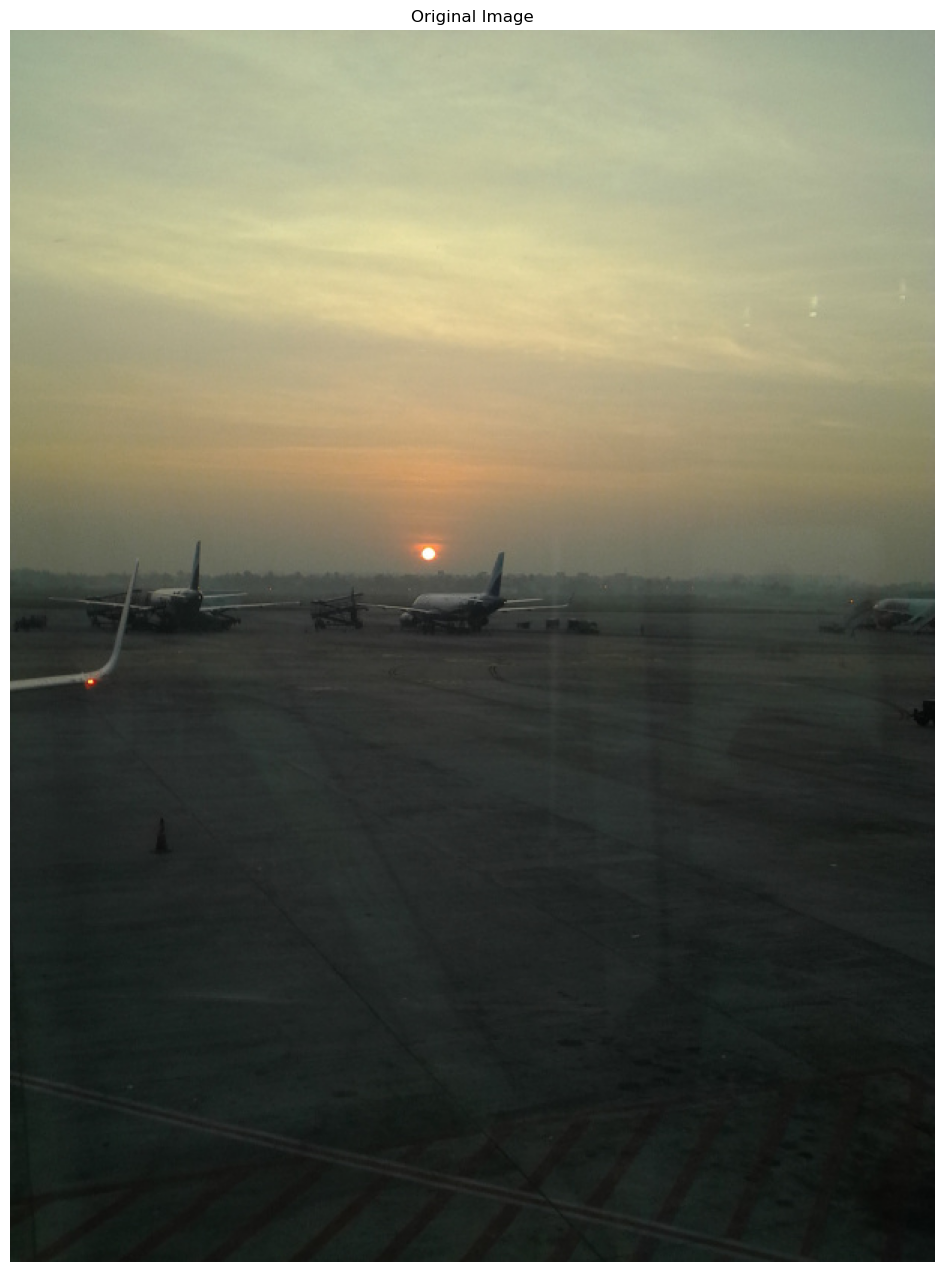

In [2]:
from skimage import data, draw, transform, util, filters, color, io
import numpy as np
from matplotlib import pyplot as plt

# Đọc ảnh từ file
image = io.imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\aero.jpg')
print(f"Image shape: {image.shape}")  # (821, 616, 3)

# Chuyển ảnh sang định dạng float
image = util.img_as_float(image)

# Tính năng lượng ảnh sử dụng bộ lọc Sobel
energy_image = filters.sobel(color.rgb2gray(image))

# Hiển thị ảnh gốc
plt.figure(figsize=(20, 16))
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.show()


Resized image shape: (821, 416, 3)


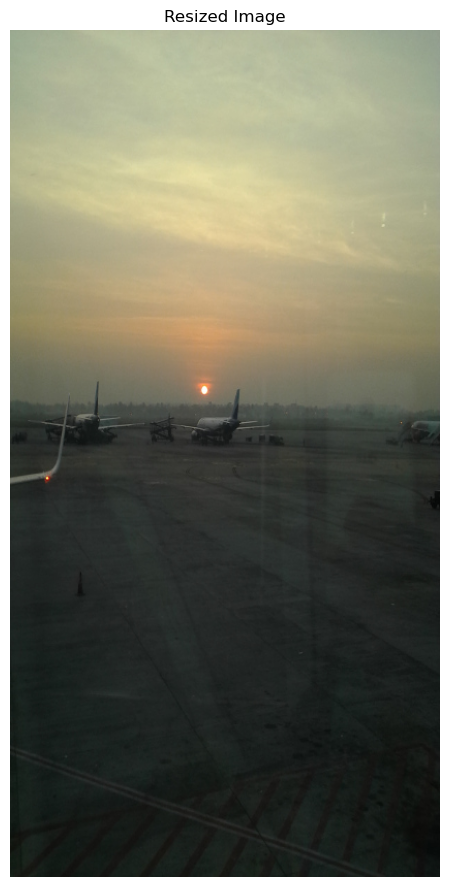

In [3]:
from skimage import transform
from matplotlib import pyplot as plt

# Thay đổi kích thước ảnh
resized = transform.resize(image, (image.shape[0], image.shape[1] - 200), mode='reflect')
print(f"Resized image shape: {resized.shape}")  # (821, 416, 3)

# Hiển thị ảnh đã thay đổi kích thước
plt.figure(figsize=(20, 11))
plt.title('Resized Image')
plt.imshow(resized)
plt.axis('off')
plt.show()


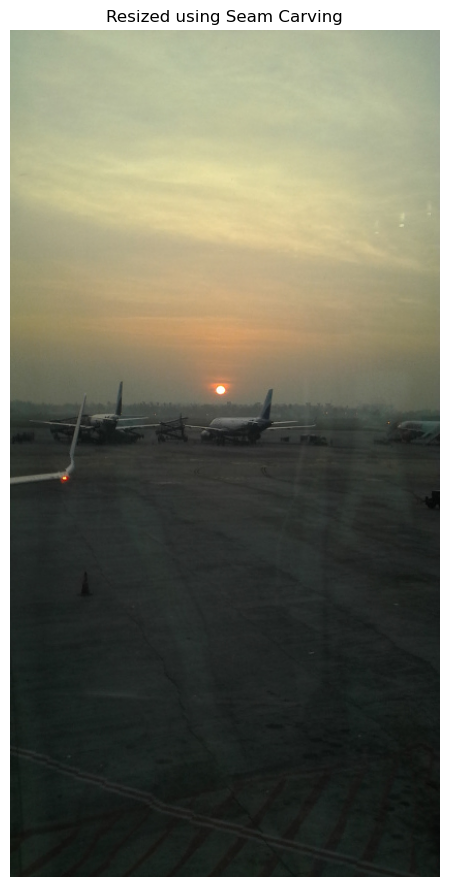

In [ ]:
from skimage import io, util, color, filters
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

# Tính năng lượng ảnh sử dụng Sobel
def compute_energy(image):
    gray = color.rgb2gray(image)  # Chuyển ảnh sang xám
    dx = sobel(gray, axis=1)  # Gradient theo trục x
    dy = sobel(gray, axis=0)  # Gradient theo trục y
    return np.hypot(dx, dy)  # Tổng hợp năng lượng

# Tìm seam có năng lượng nhỏ nhất theo chiều dọc
def find_seam(energy):
    h, w = energy.shape
    cost = energy.copy()
    backtrack = np.zeros_like(cost, dtype=np.int)

    for row in range(1, h):
        for col in range(w):
            min_cost = cost[row - 1, col]
            offset = 0

            if col > 0 and cost[row - 1, col - 1] < min_cost:
                min_cost = cost[row - 1, col - 1]
                offset = -1
            if col < w - 1 and cost[row - 1, col + 1] < min_cost:
                min_cost = cost[row - 1, col + 1]
                offset = 1

            cost[row, col] += min_cost
            backtrack[row, col] = offset

    seam = np.zeros(h, dtype=np.int)
    seam[-1] = np.argmin(cost[-1])
    for row in range(h - 2, -1, -1):
        seam[row] = seam[row + 1] + backtrack[row + 1, seam[row + 1]]

    return seam

# Xóa seam từ ảnh
def remove_seam(image, seam):
    h, w, c = image.shape
    output = np.zeros((h, w - 1, c))
    for row in range(h):
        col = seam[row]
        output[row, :, :] = np.delete(image[row, :, :], col, axis=0)
    return output

# Seam Carving
def seam_carving(image, num_seams):
    for _ in range(num_seams):
        energy = compute_energy(image)
        seam = find_seam(energy)
        image = remove_seam(image, seam)
    return image

# Đọc ảnh và chuyển sang kiểu float
image_path = 'D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\aero.jpg'
image = io.imread(image_path)
image = util.img_as_float(image)  # Chuyển ảnh sang định dạng float

# Áp dụng Seam Carving để giảm 200 pixel theo chiều ngang
num_seams = 200
resized_image = seam_carving(image, num_seams)

# Hiển thị ảnh kết quả
plt.figure(figsize=(20, 11))
plt.title('Resized using Seam Carving')
plt.imshow(resized_image)
plt.axis('off')
plt.show()


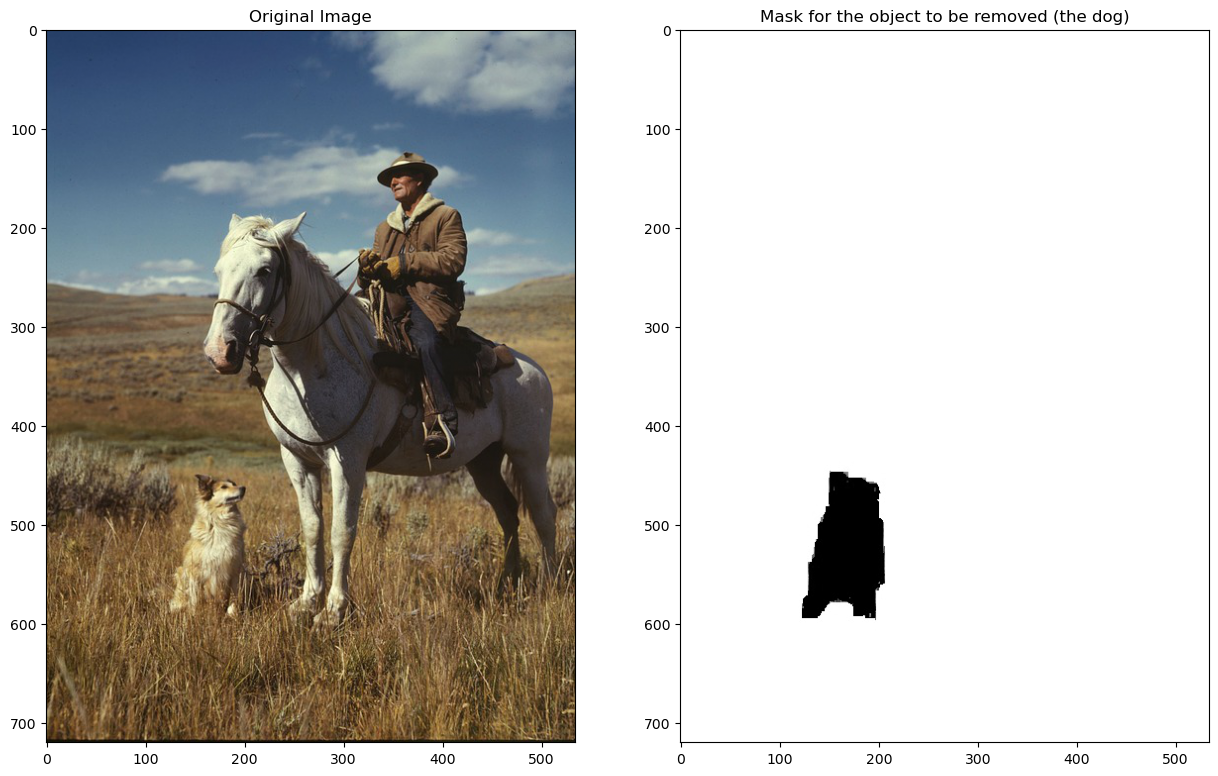

KeyboardInterrupt: 

In [ ]:
import numpy as np
from skimage import io, color
from skimage.util import img_as_float
from skimage.filters import sobel
from skimage.transform import resize
import matplotlib.pyplot as plt

# Đọc ảnh gốc và mask
image = img_as_float(io.imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\man.jpg'))
mask_img = color.rgb2gray(io.imread('D:\\Learn DL\\Xử lý ảnh\\BTL\\Sandipan_Dey_2018_Sample_Images\\images\\man_mask.jpg'))

# Đảm bảo mask có cùng kích thước với ảnh
if mask_img.shape != image.shape[:2]:
    mask_img = resize(mask_img, image.shape[:2], mode='reflect', anti_aliasing=True)

# Hiển thị ảnh gốc và mask
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(mask_img, cmap='gray')
plt.title('Mask for the object to be removed (the dog)')
plt.show()

# Tính bản đồ năng lượng
def compute_energy(image):
    """Hàm tính năng lượng ảnh bằng đạo hàm Sobel"""
    gray = color.rgb2gray(image)
    energy = sobel(gray)
    return energy

# Tích hợp mask để giảm năng lượng vùng cần xóa
def apply_mask(energy, mask):
    """Hàm áp dụng mask, giảm năng lượng vùng được đánh dấu trong mask"""
    energy = energy.copy()
    energy += mask * -1000  # Giá trị âm lớn để ưu tiên xóa vùng này
    return energy

# Seam carving: Tìm và loại bỏ seam năng lượng thấp nhất
def remove_seam(image, energy):
    """Hàm loại bỏ seam năng lượng thấp nhất khỏi ảnh"""
    rows, cols, _ = image.shape
    seam_energy = np.zeros((rows, cols))
    backtrack = np.zeros((rows, cols), dtype=int)

    # Sao chép năng lượng hàng đầu
    seam_energy[0, :] = energy[0, :]

    # Tính seam năng lượng thấp nhất
    for i in range(1, rows):
        for j in range(cols):
            min_energy = seam_energy[i-1, j]
            if j > 0:
                min_energy = min(min_energy, seam_energy[i-1, j-1])
            if j < cols-1:
                min_energy = min(min_energy, seam_energy[i-1, j+1])
            seam_energy[i, j] = energy[i, j] + min_energy
            if j > 0 and seam_energy[i, j] == energy[i, j] + seam_energy[i-1, j-1]:
                backtrack[i, j] = -1
            elif j < cols-1 and seam_energy[i, j] == energy[i, j] + seam_energy[i-1, j+1]:
                backtrack[i, j] = 1

    # Xóa seam
    new_image = np.zeros((rows, cols-1, 3))
    seam = np.zeros(rows, dtype=int)
    seam[-1] = np.argmin(seam_energy[-1])
    for i in range(rows-1, -1, -1):
        col = seam[i]
        new_image[i, :, :] = np.delete(image[i, :, :], col, axis=0)
        if i > 0:
            seam[i-1] = seam[i] + backtrack[i, seam[i]]

    return new_image

# Tích hợp mask vào năng lượng và thực hiện xóa đối tượng
output_image = image.copy()
num_seams_removed = 0
max_seams_to_remove = int(np.sum(mask_img > 0.5))  # Số seam tương ứng với số pixel vùng được đánh dấu

while num_seams_removed < max_seams_to_remove:
    if output_image.shape[1] <= 1:  # Dừng nếu ảnh chỉ còn 1 cột
        print("Reached the limit of resizing, stopping.")
        break

    energy = compute_energy(output_image)
    energy = apply_mask(energy, mask_img)
    output_image = remove_seam(output_image, energy)
    mask_img = np.delete(mask_img, np.argmin(energy[-1]), axis=1)  # Cập nhật mask
    num_seams_removed += 1

# Hiển thị kết quả cuối
plt.figure(figsize=(10, 12))
plt.title('Object (the dog) Removed')
plt.imshow(output_image)
plt.axis('off')
plt.show()
